Example 1: Load one file into the `Resonator` class
======================

**By: Faustin Carter, 2016, updated 2018**

This notebook imports the data from one Agilent file, creates a `Resonator` object, runs a fitting routine, and then plots the data and fit curves in a nice way.

Once you've understood this example, you should be able to replicate it with your own data simply be writing a custom `process_file` function and updating the code that finds the datafile.

In [1]:
#Set up the notebook for inline plotting
%matplotlib inline

#For high-res figures. You can comment this out if you don't have a retina screen
%config InlineBackend.figure_format = 'retina' 

#For pretty printing of dicts
import pprint as pp

#Because you should always import numpy!
import numpy as np

Load up the `scraps` modules
--------------------------

You'll need to change the path to reflect wherever you stored the code

In [2]:
import os

#Add the scraps folder to the path. You can skip this if you pip installed it.
import sys
sys.path.append(os.getcwd()+'scraps/')

#Load up the resonator code!
import scraps as scr

Load a file and process the data
------------------------------

This unpacks the file data into a dict objects. This block of code is the only thing you need to change to make this work with your data.

The data dict has the following quantities:

* **I, Q, and freq**: numpy arrays of data from the VNA file

* **name**: an arbitrary string describing the resonator. This is description of the physical object. So if you run two sweeps on the same resonator at different powers or temperatures, you should give them the same name.

* **pwr, temp**: floats that describe the power in dB and the temperature in K that the measurement was taken at.

In [3]:
#Load in a file
dataFile = './ExampleData/RES-1_-10_DBM_TEMP_0.113.S2P'

#Use the process_file routine to read the file and create a dict of resonator data
fileDataDict = scr.process_file(dataFile, skiprows=1)

#Look at the contents of the dict:
pp.pprint(fileDataDict)

{'I': array([-0.022739, -0.022687, -0.02265 , ...,  0.063827,  0.063836,
        0.063869]),
 'Q': array([ 0.062457,  0.062449,  0.062447, ...,  0.02939 ,  0.029329,  0.02928 ]),
 'freq': array([  8.17088000e+09,   8.17088400e+09,   8.17088800e+09, ...,
         8.17887200e+09,   8.17887600e+09,   8.17888000e+09]),
 'name': 'RES-1',
 'pwr': -10.0,
 'temp': 0.113}


Make a `Resonator` object
-----------
You can either create a resonator object directly, or use the `makeResFromData` helper tool, which takes the data dict you made earlier as an argument. The `makeResFromData` tool also allows you to simultaneously fit the data to a model, by passing the model along.

`makeResFromData` returns a resonator object, as well as the temperature rounded to the nearest 5 mK and the power. This is for convenience when dealing with large numbers of `Resonator` objects programmatically.

The `Resonator` object takes the I, Q, and freq data and calculates magnitude and phase.

The `cmplxIQ_params` function sets up a `lmfit` `Parameters` object which can later be passed to a fitting function. It also tries to guess the baseline of the magnitude and the electrical delay (i.e. baseline) of the phase, as well as starting values for frequency and quality factor. The `cmplxIQ_fit` function is model function that uses the parameters defined in `cmplxIQ_params` that is passed to the `do_lmfit` or `do_emcee` methods of the `Resonator` object.

In [4]:
#Create a resonator object using the helper tool
resObj1 = scr.makeResFromData(fileDataDict)

#Create a resonator object using the helper tool and also fit the data
#To do this, we pass a function that initializes the parameters for the fit, and also the fit function
resObj2 = scr.makeResFromData(fileDataDict, paramsFn = scr.cmplxIQ_params, fitFn = scr.cmplxIQ_fit)

#Check the temperature and power
print('Temperature = ', resObj1.temp)
print('Power = ', resObj1.pwr)

#Check to see whether a results object exists
print('Do fit results exist for the first object? ', resObj1.hasFit)
print('Do fit results exist for the second object? ', resObj2.hasFit)


#Explicitly call the fitter on the first object.
#Here we will call it, and also override the guess for coupling Q with our own quess
resObj1.load_params(scr.cmplxIQ_params)
resObj1.do_lmfit(scr.cmplxIQ_fit, qc=5000)

#Check to see whether a results object exists again, now they are both True
print('Do fit results exist for the first object? ', resObj1.hasFit)
print('Do fit results exist for the second object? ', resObj2.hasFit)

#Compare the best guess for the resonant frequency (minimum of the curve) to the actual fit
print('Guess = ', resObj2.fmin, ' Hz')
print('Best fit = ', resObj2.lmfit_result.params['f0'].value, ' Hz')
print('Best fit with different qc guess = ', resObj1.lmfit_result.params['f0'].value, ' Hz')

#You can see the fit is not terribly sensitive to the guess for qc.

Temperature =  0.113
Power =  -10.0
Do fit results exist for the first object?  False
Do fit results exist for the second object?  True
Do fit results exist for the first object?  True
Do fit results exist for the second object?  True
Guess =  8174865993.0  Hz
Best fit =  8174865670.34  Hz
Best fit with different qc guess =  8174865670.34  Hz


Make a pretty plot
---------
Fits aren't worth anything if you don't plot the results!!

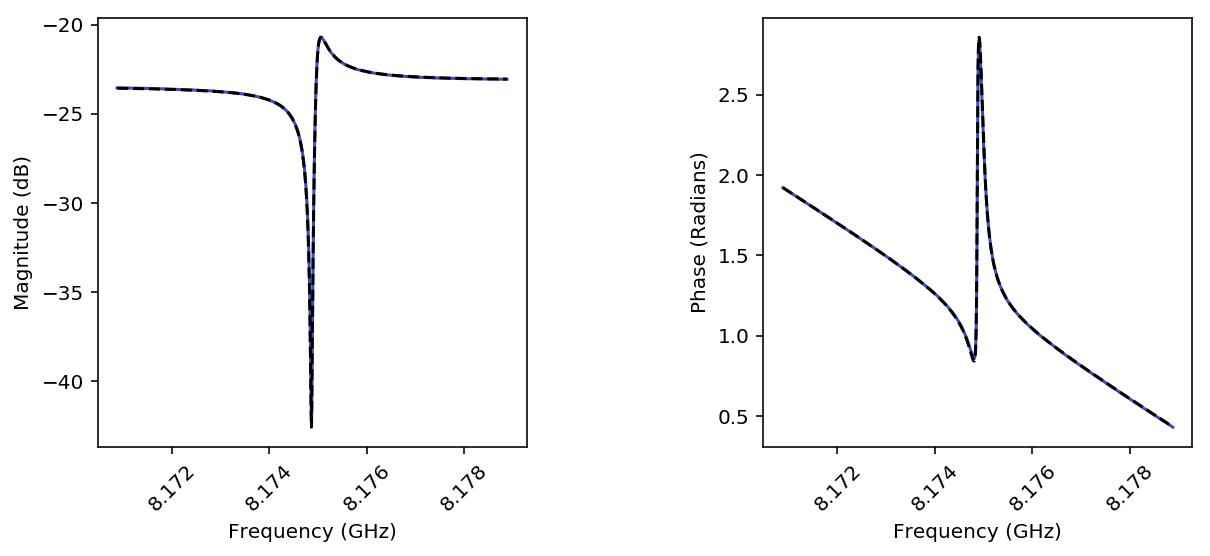

In [5]:
#When using inline plotting, you have to assign the output of the plotting functions to a figure, or it will plot twice

#This function takes a list of resonators. It can handle a single one, just need to pass it as a list:
figA = scr.plotResListData([resObj1],
                          plot_types = ['LogMag', 'Phase'], #Make two plots
                          num_cols = 2, #Number of columns
                          fig_size = 4, #Size in inches of each subplot
                          show_colorbar = False, #Don't need a colorbar with just one trace
                          force_square = True, #If you love square plots, this is for you!
                          plot_fits = [True]*2) #Overlay the best fit, need to specify for each of the plot_types

Find the maximum liklhood estimate of the fit params using ``emcee``
---
Let's use the built-in ``emcee`` hooks to compare the results of the ``lmfit`` values with the maximum liklihood values for the fit parameters.

In [6]:
#Call the emcee hook and pass it the fit function that calculates your residual.
#Since we already ran a fit, emcee will use that fit for its starting guesses.
resObj2.do_emcee(scr.cmplxIQ_fit, nwalkers = 30, steps = 1000, burn=200)

In [7]:
#Check to see that a emcee result exists
print('Does an emcee chain exist? ', resObj2.hasChain)

#Look at the first few rows of the output chain:
chains = resObj2.emcee_result.flatchain

print('\nHead of chains:')
pp.pprint(chains.head())

#Compare withe the mle values (percent difference):
#Maximum liklihood estimates (MLE) are stored in Resonator.mle_vals
#lmfit best fit values for varied parameters are in Resonator.lmfit_vals
diffs = list(zip(resObj2.mle_labels, (resObj2.mle_vals - resObj2.lmfit_vals)*100/resObj2.lmfit_vals))

print('\nPerecent difference:')
pp.pprint(diffs)

Does an emcee chain exist?  True

Head of chains:
             df            f0            qc             qi     gain0  \
0  88693.406843  8.174866e+09  48824.208882  284002.416495  0.068197   
1  88693.406843  8.174866e+09  48824.208882  284002.416495  0.068197   
2  88693.406843  8.174866e+09  48824.208882  284002.416495  0.068197   
3  88693.008781  8.174866e+09  48824.278726  284002.362452  0.068197   
4  88692.961646  8.174866e+09  48824.307274  284002.265436  0.068197   

      gain1        gain2    pgain0       pgain1  
0  1.039819  1107.969128  1.175712 -1563.858100  
1  1.039819  1107.969128  1.175712 -1563.858100  
2  1.039819  1107.969128  1.175712 -1563.858100  
3  1.039815  1107.965833  1.175712 -1563.857059  
4  1.039809  1107.965217  1.175712 -1563.857247  

Perecent difference:
[('df', -2.3923422906790731e-05),
 ('f0', 1.1886418690784143e-09),
 ('qc', 0.00068441527131252644),
 ('qi', -0.0024670336800228566),
 ('gain0', -7.8184691759815211e-05),
 ('gain1', 0.019622075027

Make a sweet giant triangle confusogram of your ``emcee`` results.
---
If you don't have ``pygtc`` installed, open a terminal and type ``pip install pygtc``. Go ahead, I'll wait...

In [8]:
import pygtc

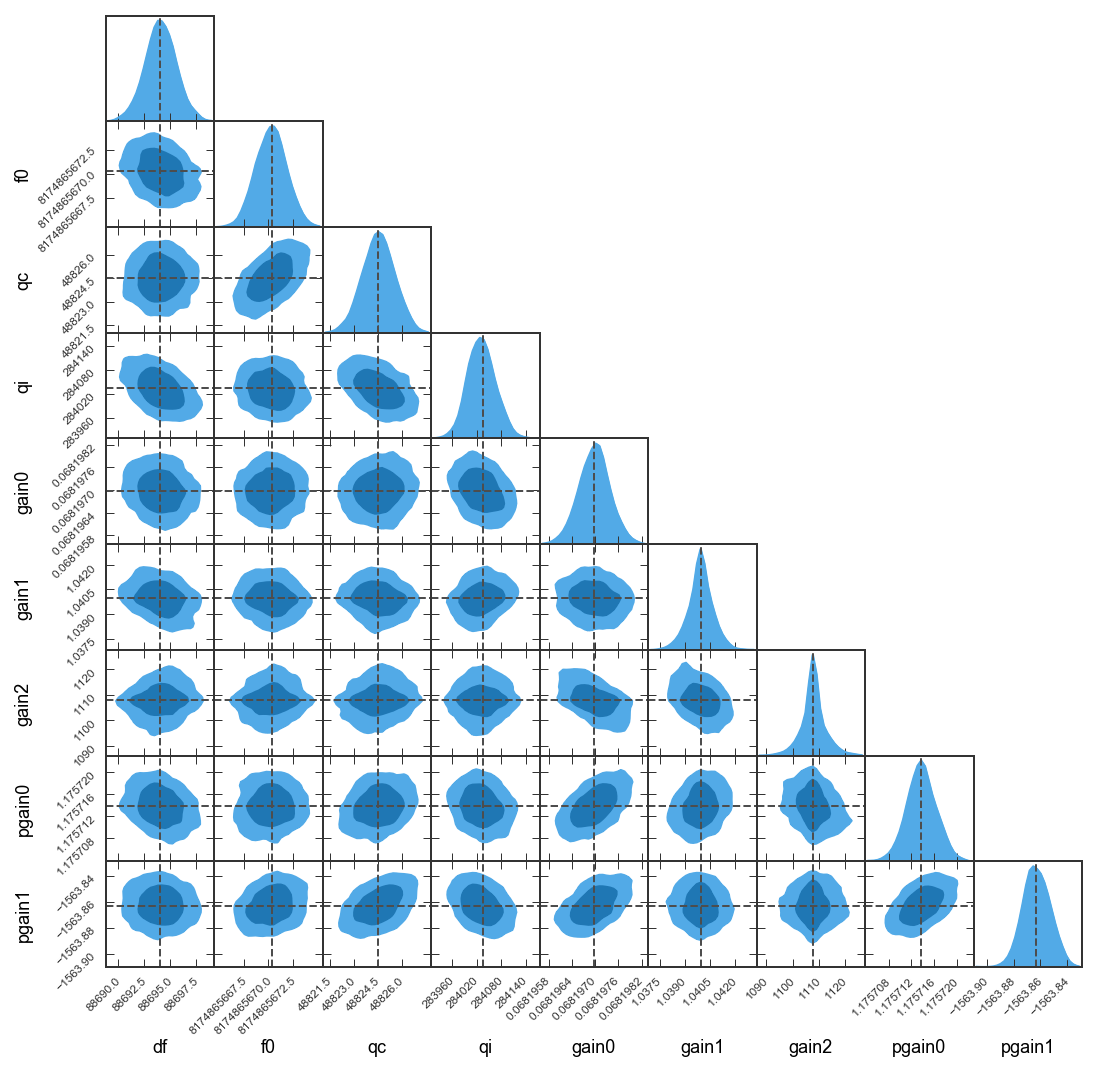

In [9]:
#Plot the triangle plot, and overlay the best fit values with dashed black lines (default)
#You can see that the least-squares fitter did a very nice job of getting the values right

#You can also see that there is some strange non-gaussian parameter space that the MCMC
#analysis maps out! This is kind of wierd, but not too worrisome. It is probably suggestive
#that more care is needed in choosing good options for the MCMC engine.

figGTC = pygtc.plotGTC(chains, truths = [resObj2.lmfit_vals])